In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression, mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from numpy import loadtxt
from keras.optimizers import SGD



## input data

In [20]:
file_name = "match_data_at_15 minute.csv"
df = pd.read_csv(file_name)

df.head(5)


,current_gold,total_gold,level,xp,cs,jg,champion_mastery,damage_taken_per_min,champion_mastery_median,champion_mastery_min,ward_placed,elite_monster_killed,building_killed,champion_killed,winner
0,2484.0,-5536.0,-4.0,-4985.0,-60.0,-16.0,0.0,-366.1,0,0,48,-1,-3,-7,1
1,-458.0,-1388.0,-2.0,-3649.0,-54.0,17.0,0.0,176.9,0,0,-80,0,-1,-5,0
2,583.0,3663.0,3.0,4584.0,-20.0,46.0,0.0,514.6,0,0,-4,-1,0,7,0
3,-338.0,-7093.0,-3.0,-3952.0,-72.0,-17.0,0.0,-80.9,0,0,-33,-4,-2,-10,1
4,-2863.0,-6852.0,-2.0,-4045.0,-92.0,-1.0,0.0,-258.9,0,0,-15,1,-4,-7,1


# Data Preprocessing

### Decide how many features to use

In [21]:
# split dataset to x and y and standardize x
def split_and_standardize_df(df):
    X = df.iloc[:,:-1]
    y = df['winner']
    X = preprocessing.scale(X)
    return X, y

def split_and_normalize_df(df):
    X = df.iloc[:,:-1]
    y = df['winner']
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit(X)
    X = scaler.transform(X)
    return X, y 

X, y = split_and_standardize_df(df)
# X, y = split_and_normalize_df(df)


X.shape

(23664, 14)

In [22]:
# evaluate how many features to include
def feature_count(X, y,model,score_func):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    fs = SelectKBest(score_func=score_func)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

    # define the grid
    grid = dict()
    grid['sel__k'] = [i for i in range(X.shape[1])]
    search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
    results = search.fit(X, y)
    print('Best Accuracy: %.3f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    df1 = pd.DataFrame(means,columns=['means'])
    df2 = pd.DataFrame(params)
    df3 = pd.concat([df1, df2], axis=1)
    df3.plot.line(x='sel__k',y='means')
    for mean, param in zip(means, params):
        print(">%.3f with: %r" % (mean, param))
    k = list(results.best_params_.values())[0]
    return k


In [23]:
def select_features(X_train, y_train, X_test, score_func, k):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k=k)
    # learn relationship from training data, fs.fit is used to calculate PCA
    fs.fit(X_train, y_train)
    # transform train input data, transform applies change of basis
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    return X_train_fs, X_test_fs

def select_features_and_split_dataset(X,y,score_func,k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    X_train, X_test = select_features(X_train, y_train, X_test, score_func, k)
    print('Train', X_train.shape, y_train.shape)
    print('Test', X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test


# Data Modeling

In [13]:
def matrix_model_accuracy(y_test,y_pred):
    result = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, y_pred)
    print("Classification Report:",)
    print (result1)


In [14]:
def model_result(model, X_train,y_train,X_test, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    matrix_model_accuracy(y_test,y_pred)
    print("--------- Training Accuracy ----------")
    y_train_pred = model.predict(X_train)
    print("Training Accuracy:",metrics.accuracy_score(y_train, y_train_pred))

    return model

In [15]:
# search for best parameters
def parameter_search(classifier, X_train, y_train, hyperF):

    gridF = GridSearchCV(classifier, hyperF, cv = 3, verbose = 1, n_jobs = -1)
    gridF.fit(X_train, y_train)
    return gridF.best_params_


## Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Best Accuracy: 0.778
Best Config: {'sel__k': 11}
>nan with: {'sel__k': 0}
>0.764 with: {'sel__k': 1}
>0.770 with: {'sel__k': 2}
>0.770 with: {'sel__k': 3}
>0.771 with: {'sel__k': 4}
>0.776 with: {'sel__k': 5}
>0.776 with: {'sel__k': 6}
>0.777 with: {'sel__k': 7}
>0.777 with: {'sel__k': 8}
>0.777 with: {'sel__k': 9}
>0.778 with: {'sel__k': 10}
>0.778 with: {'sel__k': 11}
>0.778 with: {'sel__k': 12}
>0.778 with: {'sel__k': 13}


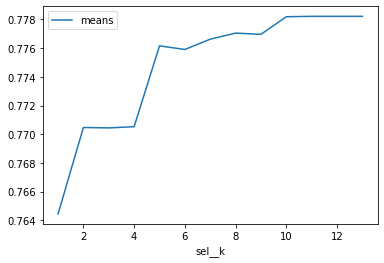

In [ ]:
# Logistic Regression feature selection
lr_model = LogisticRegression()
k = feature_count(X, y, lr_model,f_regression)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Feature 0: 1439.645841
Feature 1: 8526.335253
Feature 2: 7071.112807
Feature 3: 7957.501588
Feature 4: 1705.655730
Feature 5: 2875.605370
Feature 6: nan
Feature 7: 343.908025
Feature 8: nan
Feature 9: nan
Feature 10: 4.809877
Feature 11: 3281.843830
Feature 12: 3107.604918
Feature 13: 6091.303564


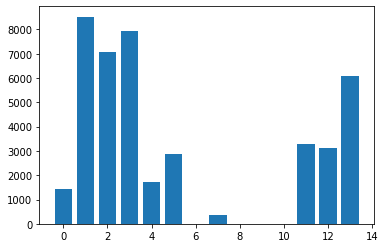

Train (16564, 11) (16564,)
Test (7100, 11) (7100,)
Accuracy: 0.7845070422535211
Confusion Matrix:
[[2751  775]
 [ 755 2819]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3526
           1       0.78      0.79      0.79      3574

    accuracy                           0.78      7100
   macro avg       0.78      0.78      0.78      7100
weighted avg       0.78      0.78      0.78      7100

--------- Training Accuracy ----------
Training Accuracy: 0.7761410287370201


In [ ]:
# model before tuning
X_train, X_test, y_train, y_test = select_features_and_split_dataset(X, y, f_regression, k)
lr_model = model_result(lr_model,X_train,y_train,X_test,y_test)

In [ ]:
# hyperparameter tuning
lr_params = {'tol': [1e-5, 1e-3, 1e-2],
             'C': [0.05, 0.1, 0.5],
             'fit_intercept': [True, False],
             'penalty': ['l1', 'l2'],
             'max_iter': [50, 100]}
best_param = parameter_search(lr_model, X_train, y_train, lr_params)
best_param

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   11.1s finished


{'C': 0.05,
 'fit_intercept': True,
 'max_iter': 50,
 'solver': 'liblinear',
 'tol': 0.01}

In [ ]:
# model after tuning
lr_model_opt = LogisticRegression(C=0.05,penalty='l2',fit_intercept=True,max_iter=50,tol=0.01)
lr_model_opt = model_result(lr_model_opt,X_train,y_train,X_test,y_test)

Accuracy: 0.7850704225352113
Confusion Matrix:
[[2751  775]
 [ 751 2823]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      3526
           1       0.78      0.79      0.79      3574

    accuracy                           0.79      7100
   macro avg       0.79      0.79      0.79      7100
weighted avg       0.79      0.79      0.79      7100

--------- Training Accuracy ----------
Training Accuracy: 0.7762617725187153


## Random Forest Classifier

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Best Accuracy: 0.775
Best Config: {'sel__k': 12}
>nan with: {'sel__k': 0}
>0.700 with: {'sel__k': 1}
>0.745 with: {'sel__k': 2}
>0.745 with: {'sel__k': 3}
>0.753 with: {'sel__k': 4}
>0.764 with: {'sel__k': 5}
>0.765 with: {'sel__k': 6}
>0.769 with: {'sel__k': 7}
>0.771 with: {'sel__k': 8}
>0.770 with: {'sel__k': 9}
>0.774 with: {'sel__k': 10}
>0.775 with: {'sel__k': 11}
>0.775 with: {'sel__k': 12}
>0.774 with: {'sel__k': 13}


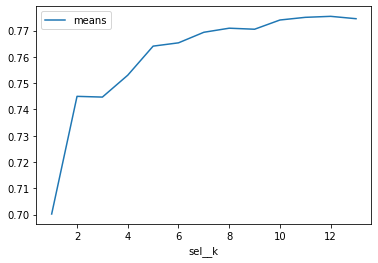

In [ ]:
# random forest feature selection 
rf_model = RandomForestClassifier()
k = feature_count(X, y, rf_model,f_regression)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Feature 0: 1439.645841
Feature 1: 8526.335253
Feature 2: 7071.112807
Feature 3: 7957.501588
Feature 4: 1705.655730
Feature 5: 2875.605370
Feature 6: nan
Feature 7: 343.908025
Feature 8: nan
Feature 9: nan
Feature 10: 4.809877
Feature 11: 3281.843830
Feature 12: 3107.604918
Feature 13: 6091.303564


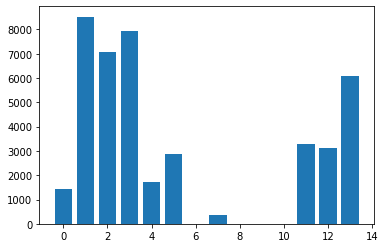

Train (16564, 12) (16564,)
Test (7100, 12) (7100,)
Accuracy: 0.7809859154929577
Confusion Matrix:
[[2718  808]
 [ 747 2827]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3526
           1       0.78      0.79      0.78      3574

    accuracy                           0.78      7100
   macro avg       0.78      0.78      0.78      7100
weighted avg       0.78      0.78      0.78      7100

--------- Training Accuracy ----------
Training Accuracy: 1.0


In [ ]:
# model before tuning
X_train, X_test, y_train, y_test = select_features_and_split_dataset(X, y, f_regression, k)
rf_model = model_result(rf_model,X_train,y_train,X_test,y_test)

In [ ]:
# hyperparameter tuning
n_estimators = [100, 300, 500]
max_depth = [3, 5, 8]
min_samples_split = [1, 2, 5]
min_samples_leaf = [5, 10]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
            min_samples_leaf = min_samples_leaf)

best_param = parameter_search(rf_model, X_train, y_train, hyperF)
best_param

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  4.6min finished


{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 300}

In [ ]:
# model after tuning
rf_model_opt = RandomForestClassifier(max_depth=5,min_samples_leaf=10,min_samples_split=5,n_estimators=300)
rf_model_opt = model_result(rf_model_opt,X_train,y_train,X_test,y_test)

Accuracy: 0.7791549295774648
Confusion Matrix:
[[2674  852]
 [ 716 2858]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3526
           1       0.77      0.80      0.78      3574

    accuracy                           0.78      7100
   macro avg       0.78      0.78      0.78      7100
weighted avg       0.78      0.78      0.78      7100

--------- Training Accuracy ----------
Training Accuracy: 0.7774088384448201


## SVM 


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Best Accuracy: 0.757
Best Config: {'sel__k': 11}
>nan with: {'sel__k': 0}
>0.741 with: {'sel__k': 1}
>0.753 with: {'sel__k': 2}
>0.755 with: {'sel__k': 3}
>0.755 with: {'sel__k': 4}
>0.753 with: {'sel__k': 5}
>0.756 with: {'sel__k': 6}
>0.753 with: {'sel__k': 7}
>0.752 with: {'sel__k': 8}
>0.751 with: {'sel__k': 9}
>0.756 with: {'sel__k': 10}
>0.757 with: {'sel__k': 11}
>0.757 with: {'sel__k': 12}
>0.757 with: {'sel__k': 13}


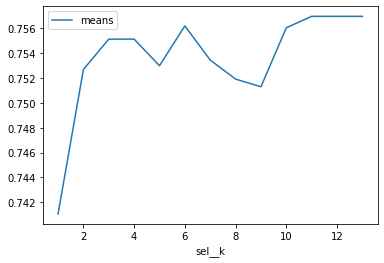

In [16]:
svm_model = svm.SVC()
k = feature_count(X, y, svm_model,f_regression)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Feature 0: 1439.645841
Feature 1: 8526.335253
Feature 2: 7071.112807
Feature 3: 7957.501588
Feature 4: 1705.655730
Feature 5: 2875.605370
Feature 6: nan
Feature 7: 343.908025
Feature 8: nan
Feature 9: nan
Feature 10: 4.809877
Feature 11: 3281.843830
Feature 12: 3107.604918
Feature 13: 6091.303564


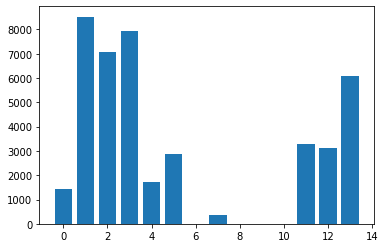

Train (16564, 11) (16564,)
Test (7100, 11) (7100,)
Accuracy: 0.7853521126760563
Confusion Matrix:
[[2727  799]
 [ 725 2849]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3526
           1       0.78      0.80      0.79      3574

    accuracy                           0.79      7100
   macro avg       0.79      0.79      0.79      7100
weighted avg       0.79      0.79      0.79      7100

--------- Training Accuracy ----------
Training Accuracy: 0.7808500362231345


In [24]:
X_train, X_test, y_train, y_test = select_features_and_split_dataset(X, y, f_regression, k)
svm_model = model_result(svm_model,X_train,y_train,X_test,y_test)

In [27]:
param_grid = {'C': [0.001,0.1, 1, 5],
              'gamma': [0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear', 'poly', 'rbf']}

best_param = parameter_search(svm_model, X_train, y_train, param_grid)
best_param

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 10.4min finished


{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

In [28]:
svm_model_opt = svm.SVC(C=0.1,gamma=0.001,kernel='linear')
svm_model_opt = model_result(svm_model_opt,X_train,y_train,X_test,y_test)


Accuracy: 0.7846478873239436
Confusion Matrix:
[[2750  776]
 [ 753 2821]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      3526
           1       0.78      0.79      0.79      3574

    accuracy                           0.78      7100
   macro avg       0.78      0.78      0.78      7100
weighted avg       0.78      0.78      0.78      7100

--------- Training Accuracy ----------
Training Accuracy: 0.7756580536102391


## KNN

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Best Accuracy: 0.748
Best Config: {'sel__k': 5}
>nan with: {'sel__k': 0}
>0.733 with: {'sel__k': 1}
>0.739 with: {'sel__k': 2}
>0.737 with: {'sel__k': 3}
>0.739 with: {'sel__k': 4}
>0.748 with: {'sel__k': 5}
>0.745 with: {'sel__k': 6}
>0.744 with: {'sel__k': 7}
>0.742 with: {'sel__k': 8}
>0.743 with: {'sel__k': 9}
>0.742 with: {'sel__k': 10}
>0.745 with: {'sel__k': 11}
>0.745 with: {'sel__k': 12}
>0.745 with: {'sel__k': 13}
Feature 0: 2055.097230
Feature 1: 12372.585728
Feature 2: 10288.120276
Feature 3: 11449.028178
Feature 4: 2325.613998
Feature 5: 4040.183340
Feature 6: nan
Feature 7: 514.853614
Feature 8: nan
Feature 9: nan
Feature 10: 7.339054
Feature 11: 4881.489999
Feature 12: 4504.127537
Feature 13: 8969.336229


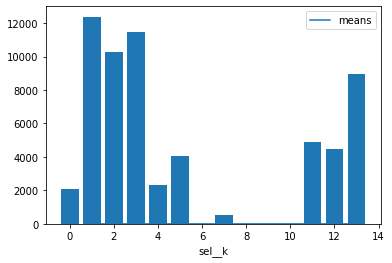

Train (23427, 5) (23427,)
Test (237, 5) (237,)


In [ ]:
knn_model = KNeighborsClassifier()
k = feature_count(X, y, knn_model,f_regression)
X_train, X_test, y_train, y_test = select_features_and_split_dataset(X, y, f_regression, k)


In [ ]:
leaf_size = [1,5]
n_neighbors = [5,10,30,40,50]
p=[1,2]

knn_model = KNeighborsClassifier()
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
best_param = parameter_search(knn_model, X, y, hyperparameters)
best_param

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.3min finished


{'leaf_size': 1, 'n_neighbors': 50, 'p': 2}

In [ ]:
knn_model_opt = KNeighborsClassifier(leaf_size = 1, n_neighbors = 50, p = 2)
knn_model = model_result(knn_model_opt,X_train,y_train,X_test,y_test)

Accuracy: 0.7890295358649789
Confusion Matrix:
[[100  31]
 [ 19  87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       131
           1       0.74      0.82      0.78       106

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237

--------- Training Accuracy ----------
Training Accuracy: 0.7794425235838989


## Neural Network

In [ ]:

classifier = Sequential()
classifier.add(Dense(200,input_dim=11))
classifier.add(Dense(100, activation='relu'))
classifier.add(Dense(50, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

opt = SGD(lr=0.01)
classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs=150, batch_size=32)

y_pred = classifier.predict(X_test)

_, accuracy = classifier.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/150
40/40 [==============================] - 0s 1ms/step - loss: 0.6582 - accuracy: 0.5942
Epoch 2/150
40/40 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.7704
Epoch 3/150
40/40 [==============================] - 0s 1ms/step - loss: 0.5289 - accuracy: 0.7703
Epoch 4/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4933 - accuracy: 0.7926
Epoch 5/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.7626
Epoch 6/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4821 - accuracy: 0.7870
Epoch 7/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.7846
Epoch 8/150
40/40 [==============================] - 0s 1ms/step - loss: 0.4716 - accuracy: 0.7614
Epoch 9/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7890
Epoch 10/150
40/40 [==============================] - 0s 2ms/step - loss: 0.4776 - accuracy: 0.7745
Epoch 11/